# Setup

In [2]:
import sys
from abc import ABC, abstractmethod
sys.path.append('..')

import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import log_loss

import model
from utils.data_utils import Season
from utils.model_utils import Feature
from data.load_footystats import GenerateDataFrame
from data.process import DataProcessor, DataSet
from data.load_csv import DataLoader

from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Data Load

In [4]:
df_past1 = GenerateDataFrame(season=Season.Past1).load()
df_past2 = GenerateDataFrame(season=Season.Past2).load()
df_past5 = GenerateDataFrame(season=Season.Past5).load()
df_past10 = GenerateDataFrame(season=Season.Past10).load()

In [25]:
data, _, _ = model.pre_process_data(df_past10)
data = data.X

# Implied Probability Computation

In [ ]:
data['B365HProb'] = 1 / data['B365H']
data['B365DProb'] = 1 / data['B365D']
data['B365AProb'] = 1 / data['B365A']

# Adjust the implied probabilities to remove the over-round
ip_sum = data['B365HProb'] + data['B365DProb'] + data['B365AProb']
over_round = ip_sum - 1
adjust = over_round / ip_sum

data['B365HProb'] -= adjust * data['B365HProb']
data['B365DProb'] -= adjust * data['B365DProb']
data['B365AProb'] -= adjust * data['B365AProb']

# Plot Implied Probabilities vs. Actual Probabilities

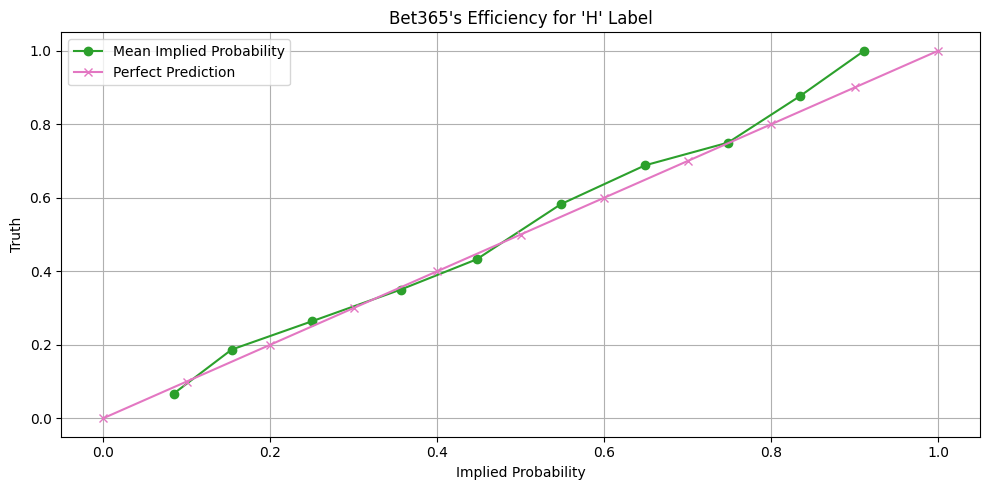

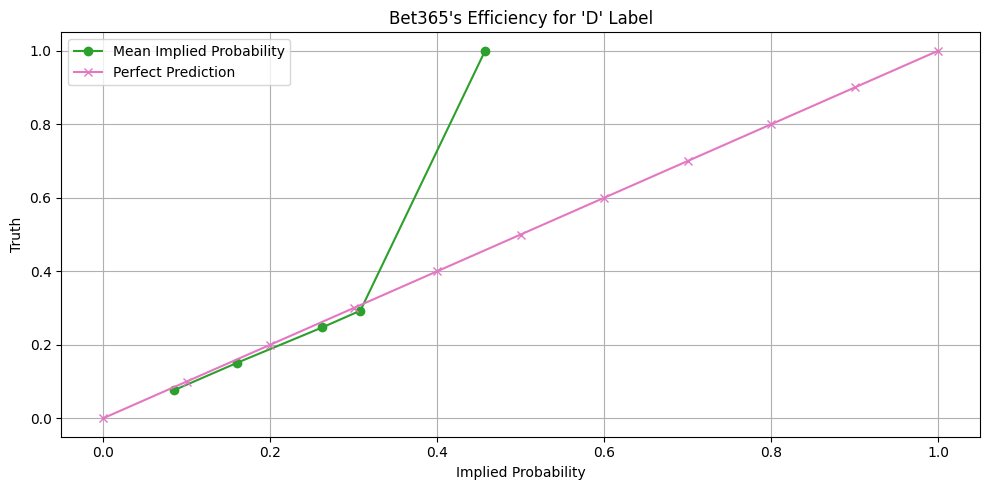

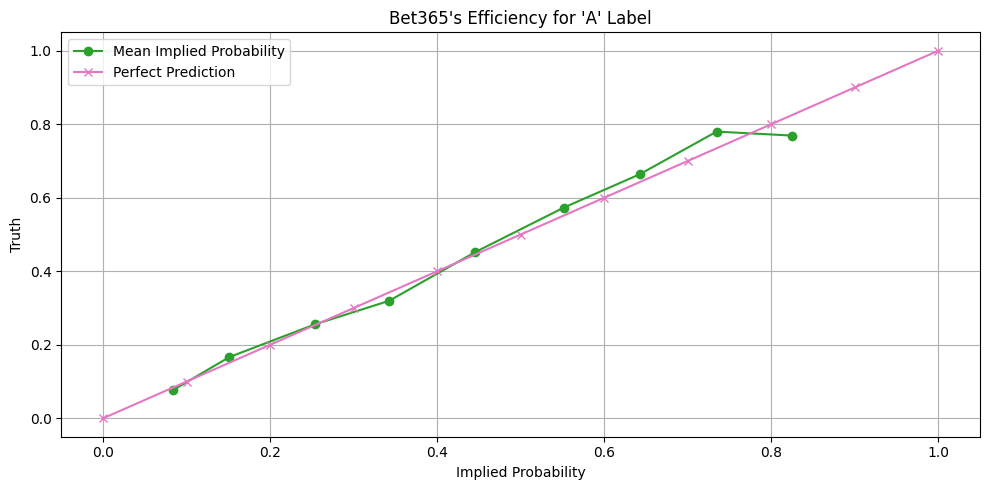

In [65]:

bins = [x / 10 for x in range(11)]
for label in ['H', 'D', 'A']:
    data['bins'] = pd.cut(data[f'B365{label}Prob'], bins=bins)
    
    # Compute the real percentage and implied probablility of each outcome for each bin
    real_prob = data.groupby('bins').apply(lambda x: (x['FTR'] == label).mean())
    implied_prob = data.groupby('bins')[f'B365{label}Prob'].mean()
    
    plt.figure(figsize=(10, 5))
    plt.plot(implied_prob, real_prob, marker='o', color='tab:green')
    plt.plot(bins, bins, color='tab:pink', marker='x')
    plt.title(f"Bet365's Efficiency for '{label}' Label")
    plt.xlabel('Implied Probability')
    plt.ylabel('Truth')

    # add legend
    plt.legend(['Mean Implied Probability', 'Perfect Prediction'])
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'fb_bias_{label}.pdf')

plt.show()

# Plot Receiver Operating Characteristic (ROC) curve and compute Area Under the Curve (AUC)

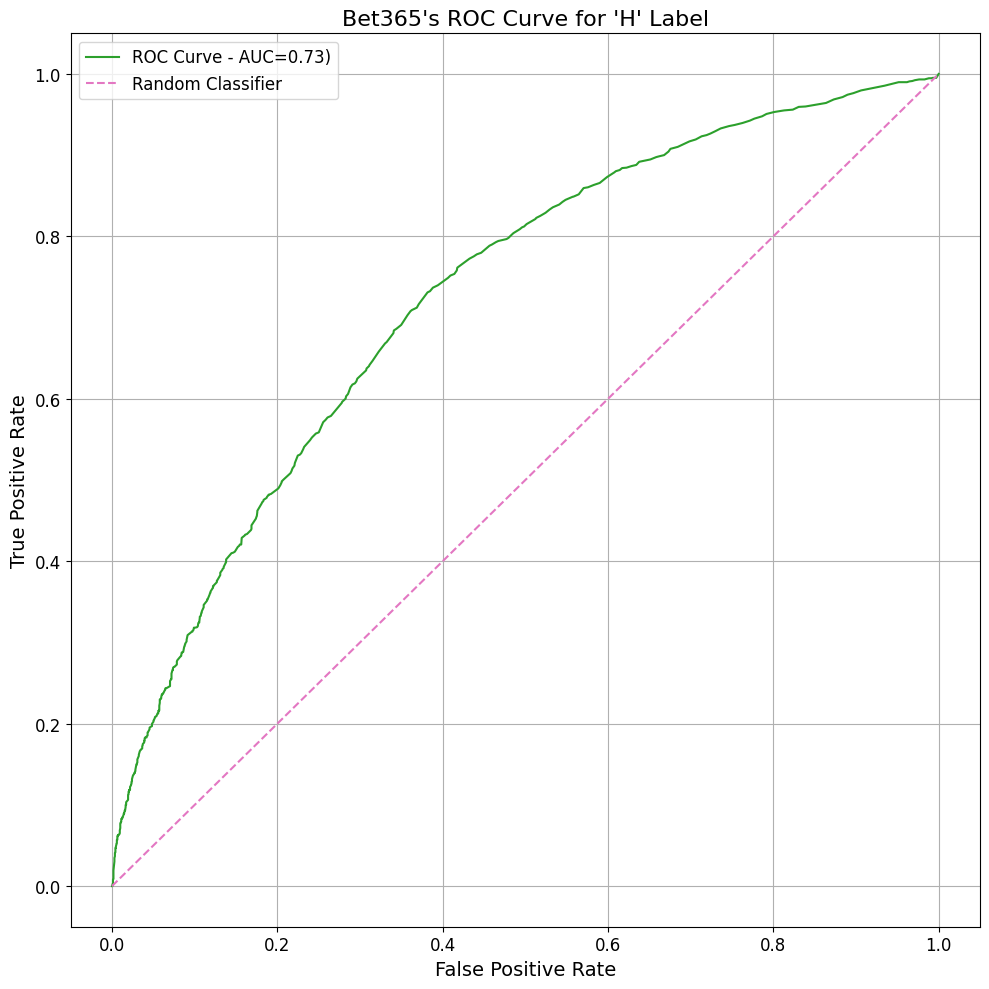

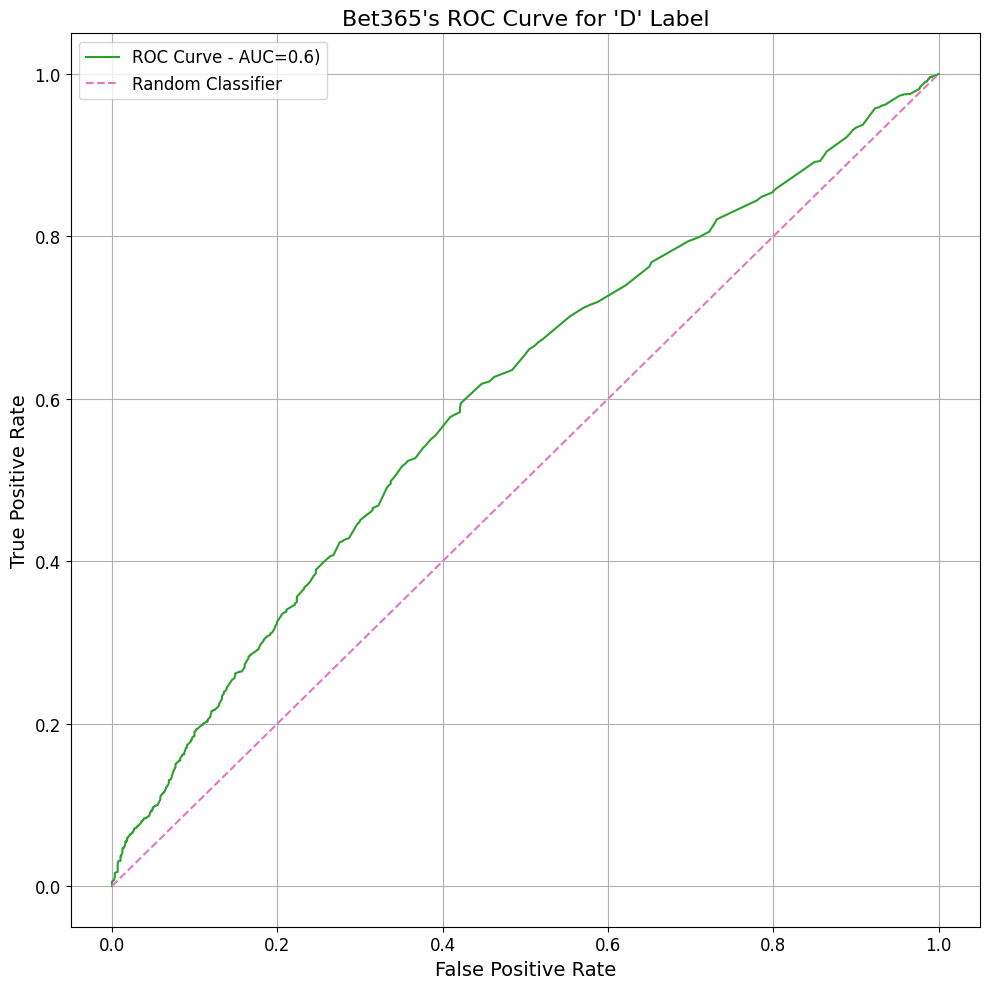

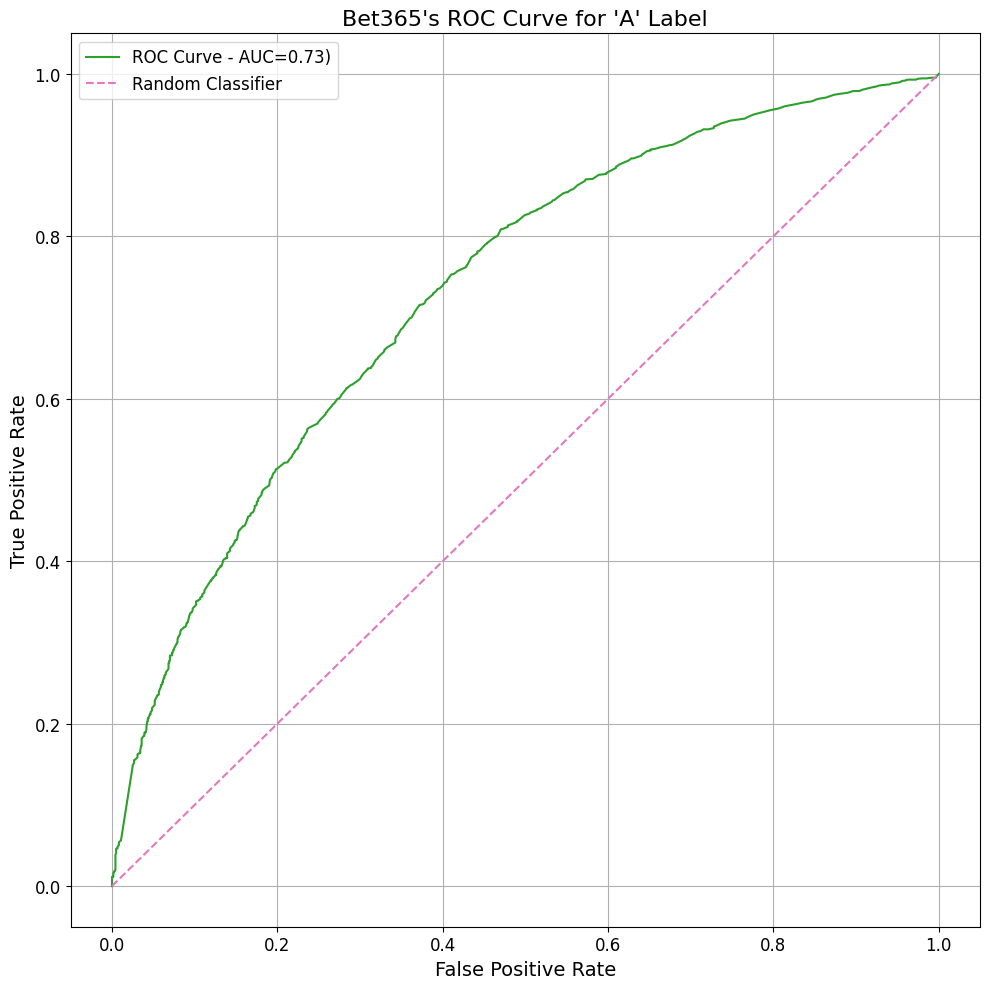

In [78]:
for label in ['H', 'D', 'A']:
    fpr, tpr, _ = roc_curve(data['FTR'] == label, data[f'B365{label}'])
    plt.figure(figsize=(10, 10))
    plt.plot(tpr, fpr, color='tab:green')
    plt.plot([0, 1], [0, 1], color='tab:pink', linestyle='--')
    plt.title(f"Bet365's ROC Curve for '{label}' Label", fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    area = 1 - round(roc_auc_score(data['FTR'] == label, data[f'B365{label}']), 2)
    plt.legend([f'ROC Curve - AUC={area})', 'Random Classifier'], fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'fb_roc_{label}.pdf')

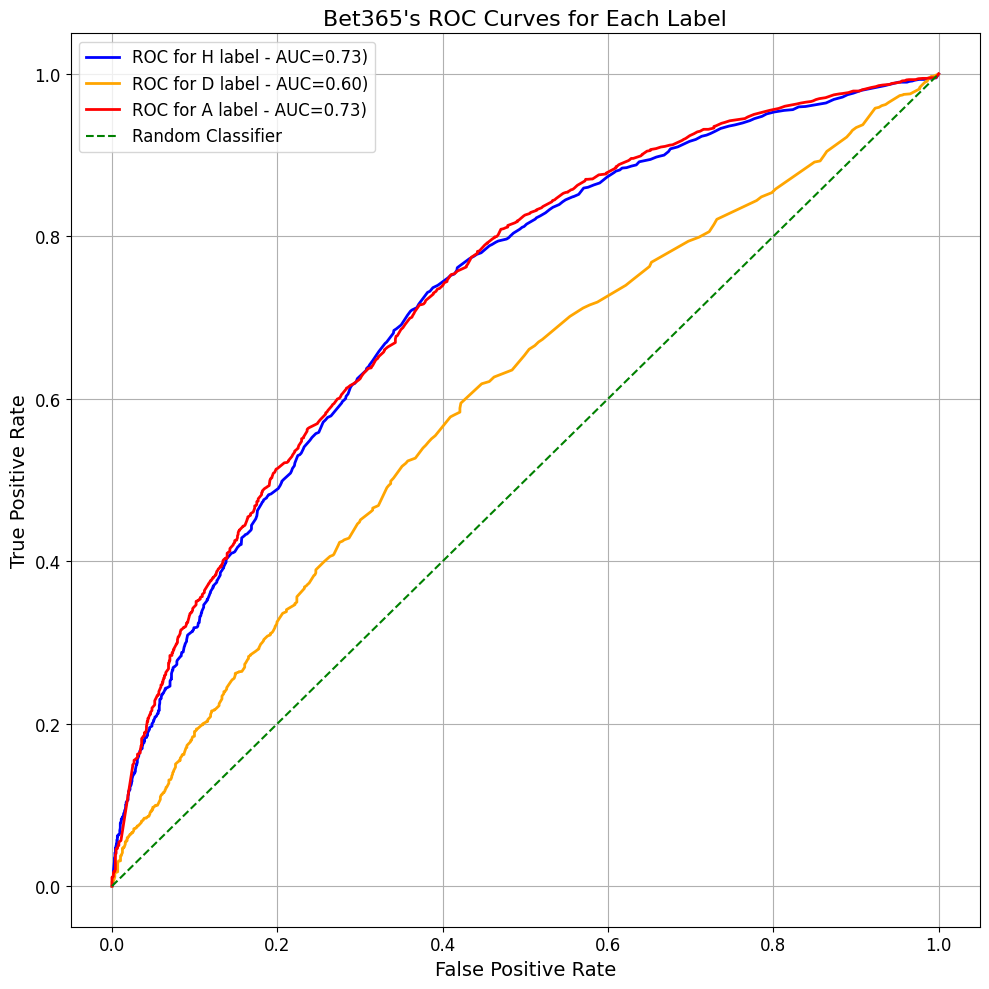

In [90]:
from sklearn.metrics import roc_curve, roc_auc_score

# Plot ROC curves for the bookmakers' odds for each outcome on the same plot
plt.figure(figsize=(10, 10))

colors = ['blue', 'orange', 'red']
labels = ['H', 'D', 'A']

for label, color in zip(labels, colors):
    fpr, tpr, _ = roc_curve(data['FTR'] == label, data[f'B365{label}'])
    roc_auc = 1 - roc_auc_score(data['FTR'] == label, data[f'B365{label}'])
    plt.plot(tpr, fpr, color=color, label=f"ROC for {label} label - AUC={roc_auc:.2f})", linewidth=2)

plt.plot([0, 1], [0, 1], color='green', linestyle='--', label='Random Classifier')
plt.title("Bet365's ROC Curves for Each Label", fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.savefig('fb_roc_all.pdf')
plt.show()

# Backtesting

## Data Setup

In [112]:
df = GenerateDataFrame(season=Season.Past6).load()

In [138]:
curr_train_test = df.iloc[:200]
curr_remaining = df.iloc[200:1150]

len(curr_train_test), len(curr_remaining)

(200, 950)

In [113]:
MATCHES_PER_ROUND = 10
START_INDEX = 1710
START_BANKROLL = 100

PARAMS = {
    Feature.ODDS.value: True,
    Feature.LAST_N_MATCHES.value: True,
    Feature.WIN_STREAK.value: True,
    Feature.PI_RATINGS.value: True,
}

def pre_process_data(df) -> tuple[DataSet, DataSet, list[str]]:
    data_processor = DataProcessor(df)
    unique_teams = data_processor.get_unique_teams()
    train, test = data_processor.split_data_last_n(n=MATCHES_PER_ROUND)

    return train, test, unique_teams

def update_datasets(curr_train_test: pd.DataFrame, curr_remaining: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    curr_train_test = pd.concat([curr_train_test, curr_remaining.iloc[:MATCHES_PER_ROUND]])
    curr_remaining = curr_remaining.iloc[MATCHES_PER_ROUND:]

    return curr_train_test, curr_remaining

def feature_engineering(curr_train_test: pd.DataFrame, params: dict[str, bool]=PARAMS) -> tuple[pd.DataFrame, pd.DataFrame, list[str], list[str]]:
    train, test, unique_teams = pre_process_data(curr_train_test)
    X_train, y_train, X_test, y_test = model.feature_engineering(train, test, unique_teams, params)

    return X_train, y_train, X_test, y_test

## Strategy Initialisation

In [114]:
class Strat(ABC):
    def __init__(self, model, start_bankroll, p_threshold, bet_size=None):
        self.model = model
        self.p_threshold = p_threshold
        self.bet_size = bet_size

        self.bankroll = start_bankroll
        self.bets = {'H': 0, 'D': 0, 'A': 0}
        self.y_test = None
        self.y_pred = None
        self.y_pred_prob = None

        self.pnl_list = []
        self.y_pred_list = []
        self.y_pred_prob_list = []
        self.y_test_list = []
        self.bankroll_list = []
    
    @abstractmethod
    def fit_model(self, X_train: pd.DataFrame, y_train: pd.Series):
        pass
    
    @abstractmethod
    def predict(self, X_test: pd.DataFrame, y_test: pd.Series):
        pass
    
    @abstractmethod
    def calc_bet_amount(self, k: float, p_threshold: float):
        pass
    
    def bet(self, X_test: pd.DataFrame, curr_train_test: pd.DataFrame) -> pd.DataFrame:
        # Odds have to be added again as in the in X_test they have been normalised
        curr_test = curr_train_test.iloc[-MATCHES_PER_ROUND:].copy().reset_index(drop=True)
        X_test['B365H'] = curr_test['B365H']
        X_test['B365D'] = curr_test['B365D']
        X_test['B365A'] = curr_test['B365A']
        
        for i, (index, row) in enumerate(X_test.iterrows()):
            prob = self.y_pred_prob.iloc[i]
            if prob < self.p_threshold:
                continue

            true_label = self.y_test.iloc[i]
            pred_label = self.y_pred.iloc[i]
            odds = row['B365' + pred_label]
            bet_amount = self.calc_bet_amount(prob, odds) if self.bet_size is None else self.bet_size

            self._bet(true_label, pred_label, odds, bet_amount)
    
    def _bet(self, true_label: str, pred_label: str, odds: float, bet_amount: float) -> float:
        if true_label == pred_label:
            pnl = bet_amount * odds - bet_amount
        else:
            pnl = -bet_amount

        # print(f'Bet: true={true_label}, pred={pred_label}, odds={odds}, amount={bet_amount}, profit={pnl}')
        self.bankroll += pnl
        self.bets[pred_label] += 1
        self.pnl_list.append(pnl)
        self.bankroll_list.append(self.bankroll)
    
    def eval_accuracy(self):
        return (pd.Series(self.y_pred_list) == pd.Series(self.y_test_list)).mean()

    def eval_sortino(self):
        pnl = pd.Series(self.pnl_list)
        neg_pnl = pnl[pnl < 0]
        return pnl.mean() / neg_pnl.std()
    
    def eval_sharpe(self):
        pnl = pd.Series(self.pnl_list)
        return pnl.mean() / pnl.std()
    
    def eval_avg_payoff(self):
        return pd.Series(self.pnl_list).mean()
    
    def eval(self):
        return {
            'pnl': sum(self.pnl_list),
            'bankroll': self.bankroll,
            'accuracy': self.eval_accuracy(),
            'sharpe': self.eval_sharpe(),
            'sortino': self.eval_sortino(),
            'avg_payoff': self.eval_avg_payoff(),
            'number_of_bets': sum(self.bets.values()),
            'home_bets': self.bets['H'],
            'away_bets': self.bets['A'],
            'draw_bets': self.bets['D'],
        }
        
    def reset(self):
        self.model = self.model.__class__(**self.model.get_params()) if self.model is not None else None
        self.y_pred = None
        self.y_pred_prob = None
        self.y_test = None

    @abstractmethod
    def calc_bet_amount(self, k: float, p_threshold: float):
        raise NotImplementedError

## Baseline Strategy

In [115]:
class Home(Strat):
    def __init__(self, model, start_bankroll, p_threshold=0.32, bet_size=1):
        super().__init__(model, start_bankroll, p_threshold, bet_size)

    def predict(self, X_test: pd.DataFrame, y_test: pd.Series):
        self.y_pred = pd.Series(['H' for _ in range(len(y_test))])
        self.y_pred_prob = pd.Series([0.33 for _ in range(len(y_test))])
        self.y_test = y_test.map({0: 'H', 1: 'A', 2: 'D'})

        self.y_pred_list.extend(self.y_pred)
        self.y_pred_prob_list.extend(self.y_pred_prob)
        self.y_test_list.extend(self.y_test)

    def fit_model(self, X_train: pd.DataFrame, y_train: pd.Series):
        pass

    def calc_bet_amount(self, k: float, p_threshold: float):
        return self.bet_size


class Favorite(Strat):
    def __init__(self, model, start_bankroll, p_threshold=0.32, bet_size=1):
        super().__init__(model, start_bankroll, p_threshold, bet_size)

    def predict(self, X_test: pd.DataFrame, y_test: pd.Series):
        self.y_pred = X_test[['B365H', 'B365A', 'B365D']].idxmin(axis=1).apply(lambda x: x[-1])
        self.y_pred_prob = pd.Series([0.33 for _ in range(len(y_test))])
        self.y_test = y_test.map({0: 'H', 1: 'A', 2: 'D'})

        self.y_pred_list.extend(self.y_pred)
        self.y_pred_prob_list.extend(self.y_pred_prob)
        self.y_test_list.extend(self.y_test)

    def fit_model(self, X_train: pd.DataFrame, y_train: pd.Series):
        pass

    def calc_bet_amount(self, k: float, p_threshold: float):
        return self.bet_size

## Half Kelly Strategy

In [116]:
class HalfKelly(Strat):
    def __init__(self, model, start_bankroll, p_threshold=0.35, k=0.5, bet_size=None):
        super().__init__(model, start_bankroll, p_threshold, bet_size)
        self.k = k

    def fit_model(self, X_train: pd.DataFrame, y_train: pd.Series):
        self.model.fit(X_train, y_train)

    def predict(self, X_test: pd.DataFrame, y_test: pd.Series):
        self.y_pred = self.model.predict(X_test)
        self.y_pred = pd.Series(self.y_pred).map({0: 'H', 1: 'A', 2: 'D'})

        self.y_pred_prob = self.model.predict_proba(X_test).max(axis=1)
        self.y_pred_prob = pd.Series(self.y_pred_prob)

        self.y_test = y_test.map({0: 'H', 1: 'A', 2: 'D'})

        self.y_pred_list.extend(self.y_pred)
        self.y_pred_prob_list.extend(self.y_pred_prob)
        self.y_test_list.extend(self.y_test)
    
    def calc_bet_amount(self, p: float, b: float) -> float:
        kelly = p - (1 - p) / b
        return kelly * self.k * self.bankroll

# Running Backtest

In [117]:
hk_xgb = HalfKelly(xgb.XGBClassifier(objective="multi:softmax", num_class=3), start_bankroll=START_BANKROLL, p_threshold=0.7, k=0.5, bet_size=1)
hk_svm = HalfKelly(SVC(kernel='rbf', C=1, gamma=0.1, probability=True), start_bankroll=START_BANKROLL, p_threshold=0.34, k=0.5, bet_size=1)
hk_rfc = HalfKelly(RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1), start_bankroll=START_BANKROLL, p_threshold=0.4, k=0.5, bet_size=1)
svm = HalfKelly(SVC(kernel='poly', C=1, gamma=0.1, probability=True, degree=3, class_weight={0: 1, 1: 1, 2: 5}), start_bankroll=START_BANKROLL, bet_size=1)
home = Home(None, start_bankroll=START_BANKROLL)
fav = Favorite(None, start_bankroll=START_BANKROLL)

strats = {
    "HK-RFC": hk_rfc,
    "HK-XGB": hk_xgb,
    "HK-SVM": hk_svm,

    "SVM": svm,
    "HOME": home,
    "FAV": fav
}

In [ ]:
i= 0
curr_train_test = df.iloc[:200]
curr_remaining = df.iloc[200:1150]

while len(curr_remaining) > 0:
    print(f"Round {i}...")
    X_train, y_train, X_test, y_test = feature_engineering(curr_train_test)

    for name, strat in strats.items():
        strat.fit_model(X_train, y_train)
        strat.predict(X_test, y_test)
        strat.bet(X_test, curr_train_test)
        strat.reset()

    curr_train_test, curr_remaining = update_datasets(curr_train_test, curr_remaining)

# Results

In [ ]:
metrics_table = pd.DataFrame([strat.eval() for strat in strats.values()], index=strats.keys())
metrics_table.T.round(2).to_csv('startsmetrics_table.csv')
metrics_table.T.round(2)

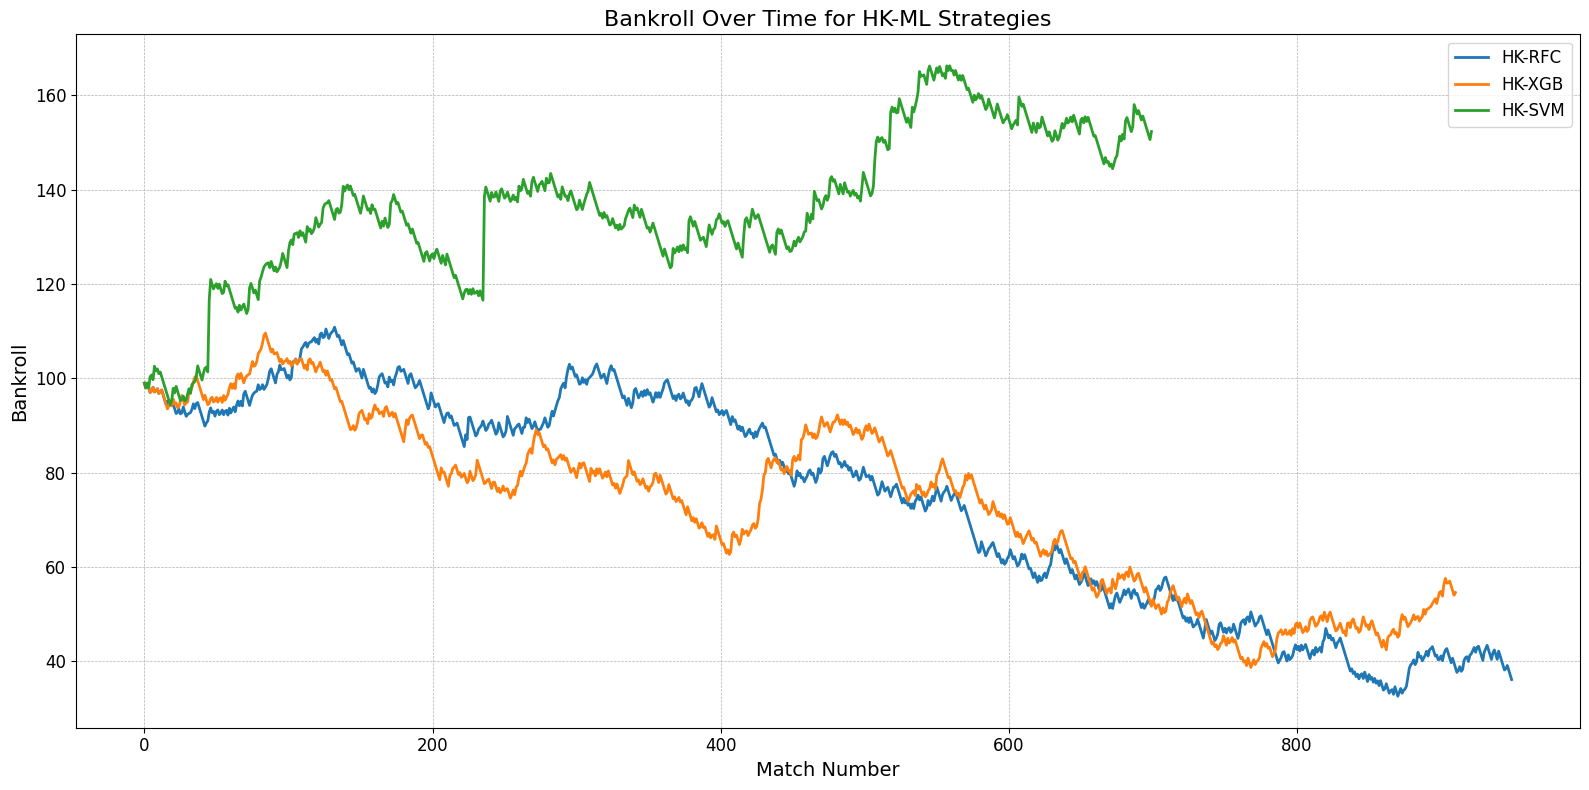

In [134]:
plt.figure(figsize=(16, 8))

for name, strat in strats.items():
    if name in ['HK-RFC', 'HK-XGB', 'HK-SVM']:
        plt.plot(strat.bankroll_list, label=name)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)

plt.title("Bankroll Over Time for HK-ML Strategies", fontsize=16)
plt.xlabel('Match Number', fontsize=14)
plt.ylabel('Bankroll', fontsize=14)
plt.tight_layout()
plt.savefig('final-hkml-strats-bankroll.pdf')

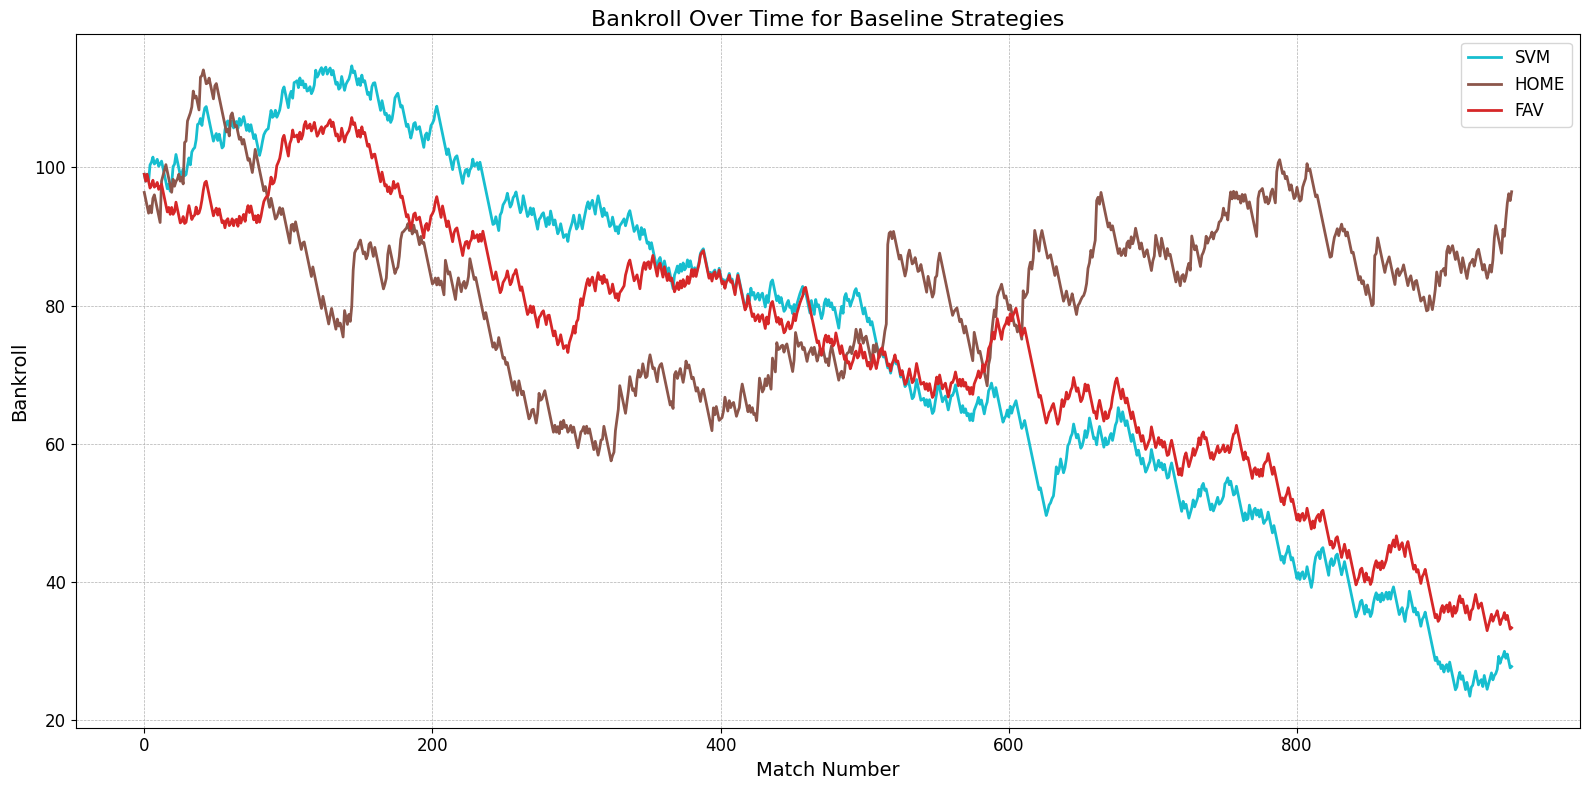

In [136]:
plt.figure(figsize=(16, 8))

colours = ['tab:cyan', 'tab:brown', 'tab:red']
for i, (name, strat) in enumerate(strats.items()):
    if name in ['SVM', 'HOME', 'FAV']:
        plt.plot(strat.bankroll_list, label=name, color=colours.pop(0))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)

plt.title("Bankroll Over Time for Baseline Strategies", fontsize=16)
plt.xlabel('Match Number', fontsize=14)
plt.ylabel('Bankroll', fontsize=14)
plt.tight_layout()
plt.savefig('final-baseline-strats-bankroll.pdf')